In [43]:
# Imports

import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.cancorr import CanCorr
import warnings
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "notebook"

#### Load data

In [44]:
# Read data

data_folder = "../data/processed/"
df_social = pd.read_csv(data_folder + "socio_extrapolated_5_country.csv", index_col=0)
df_energy = pd.read_csv(data_folder + "pcc_energy_extrapolated_5_country.csv", index_col=0)

#### Data preprocessing

In [45]:
# Make sure both energy and social data keys (entity, year) are present in both datasets. Otherwise drop those records
temp1 = list(zip(df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
temp2 = list(zip(df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
exclude_records1 = list(set(temp2) - set(temp1))
exclude_records = list(set(temp1) - set(temp2))

# Comprehensive list of keys from both datasets, that is not a part the intersection
exclude_records.extend(exclude_records1)

# Extract keys
list_energy = list(zip(df_energy['Entity'],df_energy['Year']))
list_social = list(zip(df_social['Entity'],df_social['Year']))

# Get list of all keys, that should not be excluded
list_in_energy = [x not in exclude_records for x in list_energy]
list_in_social = [x not in exclude_records for x in list_social]

# Drop unwanted records and sort remaining data (so energy and social data align in index)
df_energy = df_energy.iloc[list_in_energy,].reset_index().drop(columns='index')
df_social = df_social.iloc[list_in_social,].reset_index().drop(columns='index')
df_energy = df_energy.sort_values(['Entity','Year']).reset_index().drop(columns='index')
df_social = df_social.sort_values(['Entity','Year']).reset_index().drop(columns='index')

In [46]:
# Extract records, where we have zero nan values (combined between the two datasets) - only for columns of interest
df_energy_sub = df_energy.iloc[:,[5,6]]
df_social_sub = df_social.iloc[:,[0,1,2,5,6,8,9,10,12,13,14]]

energy_non_nan_indx = df_energy_sub.isna().sum(axis=1)==0
social_non_nan_indx = df_social_sub.isna().sum(axis=1)==0

indx_non_nan = energy_non_nan_indx & social_non_nan_indx

df_energy_sub = df_energy_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')
df_social_sub = df_social_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')

In [47]:
# Due to numerical instability with too large values, we will work with log(population)
df_social_sub.iloc[:,4] = df_social_sub.iloc[:,4]/1e6

#### Define features and target values

In [48]:
# Define target values and features
X = df_social_sub
y = df_energy_sub['Low-carbon energy per capita (kWh)']/df_energy_sub['Energy per capita (kWh)'] + 1e-7

In [78]:
# Select data 
Continent = 'all'
year_max = 2019
year_min = 2000

X1 = X.copy()
y1 = y.copy()

if Continent == 'all':
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]

    X1 = pd.concat([X1,pd.get_dummies(X1.Continent, prefix='Continent')],axis=1)
else:
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]

X1 = X1.reset_index().drop(columns='index')
y1 = y1.reset_index().drop(columns='index')

# Drop years and continent from features dataset
X2 = X1.iloc[:,3:]

#### Find optimal number of PLS components

Text(0.5, 1.0, 'hp')

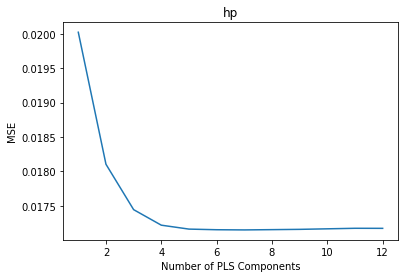

In [79]:
# Get training and test set
X_train,X_test,y_train,y_test = train_test_split(X2,y1,test_size=0.3,random_state=0) 

#define cross-validation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)

    # Calculate MSE using cross-validation, adding one component at a time
    for i in np.arange(1, 13):
        pls = PLSRegression(n_components=i)
        score = -1*model_selection.cross_val_score(pls, scale(X_train), y_train, cv=cv,
                scoring='neg_mean_squared_error').mean()
        mse.append(score)

#plot test MSE vs. number of components
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(np.arange(1,len(mse)+1,1),mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')

#### Train and test model performance

In [80]:
#calculate RMSE
pls = PLSRegression(n_components=np.argmin(mse)+1)
X_mean = X_train.mean()
X_std = X_train.std()
pls.fit(scale(X_train), y_train)

X_test_std = (X_test-X_mean)/X_std
np.sqrt(mean_squared_error(y_test, pls.predict(X_test_std.to_numpy())))

0.13667850558601294

<AxesSubplot:>

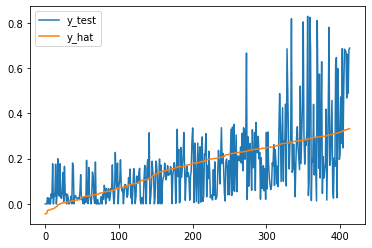

In [81]:
y_test_dat = y_test.to_numpy().ravel()
y_hat_dat = pls.predict(X_test_std.to_numpy()).ravel()

sort_indx = np.argsort(y_hat_dat)
y_test_sorted = y_test_dat[sort_indx]
y_hat_sorted = y_hat_dat[sort_indx]

test_data = pd.DataFrame({'y_test':y_test_sorted,'y_hat':y_hat_sorted, 'y_cont':X1['Continent'].iloc[X_test.index]})
test_data.plot()

In [82]:
y_cont = test_data.y_cont
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(y_cont.unique())))

mapping = {}
for indx, cont in enumerate(np.sort(y_cont.unique())):
    mapping[cont] = colors[indx]

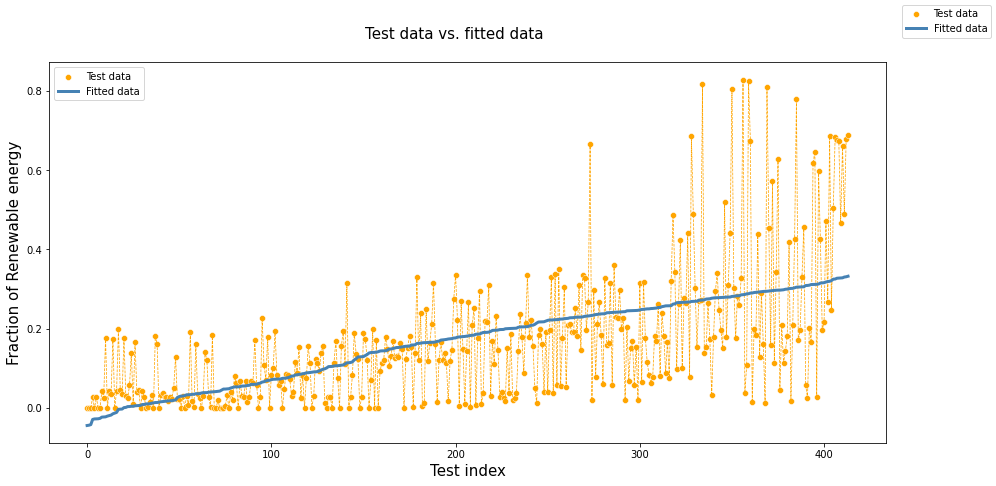

In [83]:
y_cont = X1['Continent'].iloc[X_test.index]
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(y_cont.unique())))

mapping = {}
for indx, cont in enumerate(y_cont.unique()):
    mapping[cont] = colors[indx]

col_map = [mapping[cont] for cont in y_cont]

fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=test_data, x=test_data.index, y='y_test',ax=ax, linewidth=0.75, color='orange', linestyle='--')
sns.scatterplot(data=test_data,x=test_data.index,y='y_test',ax=ax, color='orange', label='Test data')
sns.lineplot(data=test_data, x=test_data.index, y='y_hat',ax=ax, color='steelblue', linewidth=3, label='Fitted data')
ax.set_ylabel('Fraction of Renewable energy', fontsize=15)
ax.set_xlabel('Test index', fontsize=15)
fig.suptitle('Test data vs. fitted data', fontsize=15, y=0.95)
fig.legend()

#### Find R2 value of model

In [84]:
SSres = np.sum((test_data.y_test-test_data.y_hat)**2)
SStot = np.sum((test_data.y_test-np.mean(test_data.y_test))**2)

R2 = 1-SSres/SStot
print(f'R2 value is: {R2:.3f}')
print(f'The correaltion coefficient between the predicted and test values is: {np.corrcoef(test_data.y_test,test_data.y_hat)[1,0]:.3f}')

R2 value is: 0.350
The correaltion coefficient between the predicted and test values is: 0.592


#### PLS components scores

In [85]:
pls.y_loadings_

array([[ 0.21471252,  0.27201768,  0.21305102, -0.10366524,  0.06407632,
         0.0331531 ,  0.02122158]])

#### Analysis of PLS components

In [86]:
n_comp = 3

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)
    loadings=pd.DataFrame(pls.x_loadings_.T)
    loadings.columns = X2.columns

    loadings_v = loadings.unstack().reset_index()
    loadings_v.columns = ['Feature','PLS Component','Loading']

    loadings_v = loadings_v[loadings_v['PLS Component'] < n_comp]
    loadings_v['Continent'] = np.array(['Continent' in x for x in loadings_v['Feature']])
    loadings_v['x'] = np.zeros(len(loadings_v['Feature']),)
    loadings_v['PLS Component'] = loadings_v['PLS Component']+1

    loadings_v_social = loadings_v.iloc[['Continent' not in x for x in loadings_v['Feature']],:]
    loadings_v_continent = loadings_v.iloc[['Continent' in x for x in loadings_v['Feature']],:]
    loadings_v_continent.rename(columns={'Feature':'Continent'},inplace=True)
    #loadings_v_continent.loc[:,'Continent'] = np.array([x.split('_')[1] for x in loadings_v_continent['Continent']])

In [87]:
social_feats = pd.Series([x for x in loadings_v['Feature'] if 'Continent' not in x]).unique()
continents = pd.Series([x for x in loadings_v['Feature'] if 'Continent' in x]).unique()
continents = np.array([x.split('_')[1] for x in continents])
loadings_v = loadings_v.reset_index().drop(columns='index')

for indx,feat in enumerate(loadings_v['Feature']):
    if "Continent" in feat:
        loadings_v.loc[indx,'Feature'] = feat.split('_')[1]

In [88]:
loadings_v

,Feature,PLS Component,Loading,Continent,x
0,GDP per capita ($),1,0.268304,False,0.0
1,GDP per capita ($),2,-0.386097,False,0.0
2,GDP per capita ($),3,0.541340,False,0.0
3,Child mortality rate (under 5 years - %),1,-0.365907,False,0.0
4,Child mortality rate (under 5 years - %),2,0.233106,False,0.0
5,Child mortality rate (under 5 years - %),3,0.254849,False,0.0
6,Population,1,-0.161401,False,0.0
7,Population,2,0.161067,False,0.0
8,Population,3,0.467204,False,0.0
9,HDI,1,0.402705,False,0.0


In [90]:
comp = 3
colormap = {}
for indx,i in enumerate(social_feats):
    colormap[i] = px.colors.qualitative.Pastel[indx]
for indx,i in enumerate(continents):
    colormap[i] = px.colors.qualitative.Antique[indx]


fig = px.bar(loadings_v[loadings_v['PLS Component'] == comp], x="x", y="Loading", color="Feature", barmode='group',
             facet_col='Continent', facet_col_wrap=1, color_discrete_map=colormap,
             category_orders={'Continent':[True, False]},
             labels={'x':''},
             width=1300, height=400,
             facet_row_spacing = 0.125,
             hover_name="Feature",hover_data={"Loading": True,
                                              "Feature": False,
                                              "Continent": False,
                                              "x":False,
                                              "PLS Component":False})

fig.update_layout(
    xaxis = dict(
        showticklabels=False
    ),
    xaxis2 = dict(
        showticklabels=False
    ),
    xaxis3 = dict(
        showticklabels=False
    )
)

fig.update_layout(
    margin=dict(l=40, r=700, t=40, b=40)
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=1.05
))

if comp == 1:
    anno_text = str(f'         <b>PLS Component 1</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][0]:.3f}' + 
                    '</b><br><br>This PLS component seems to capture<br>'+
                    'the highly developed <b>European</b><br>'+ 
                    'countries... Etc.<br>'+
                    'Example: Iceland')
elif comp == 2:
    anno_text = str(f'         <b>PLS Component 2</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][1]:.3f}' + 
                    '</b><br><br>This PLS component seems to capture<br>'+
                    'the poorly developed <b>South</b><br>'+ 
                    '<b>American</b> countries. (weird).. Etc.<br>'+
                    'Example: Brazil')
else:
    anno_text = str(f'         <b>PLS Component 3</b><br><br>'+
                    f'The correlation coefficient <br>with the target variable is: <b>{pls.y_loadings_[0][2]:.3f}' + 
                    '</b><br><br>This PLS component seems to capture<br>'+
                    'the larger <b>Asian</b> countries. Etc<br>'+ 
                    'Example: China')

fig.add_annotation(
    yanchor="top",
    xanchor="left",
    yref = 'paper',
    xref = 'paper',
    x=1.625,
    y=1,
    text=anno_text,
    font=dict(family="Courier New, monospace", size=16, color="Black"),
    align="left",
    bordercolor="Black",
    borderwidth=1,
    borderpad=4,
    bgcolor="#EBECF0",
    showarrow=False,
    opacity=0.8,
)

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=True", "<b>Continents</b>")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=False", "<b>Social metrics</b>")))
    
fig.show()

In [98]:
y_loadings = pd.read_csv("../data/model_results/y_loadings_v.csv", index_col=0)
y_loadings.iloc[0,0]

0.2147125173722665

In [ ]:
px.bar()

In [70]:
loadings_v

,level_0,level_1,0
0,GDP per capita ($),0,0.316302
1,GDP per capita ($),1,-0.313833
2,GDP per capita ($),2,0.434531
3,GDP per capita ($),3,-0.206079
4,GDP per capita ($),4,0.012656
...,...,...,...
107,Continent_South America,3,0.485048
108,Continent_South America,4,0.536273
109,Continent_South America,5,-0.318292
110,Continent_South America,6,-0.055849


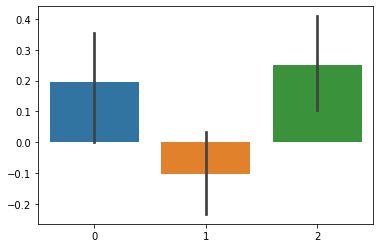

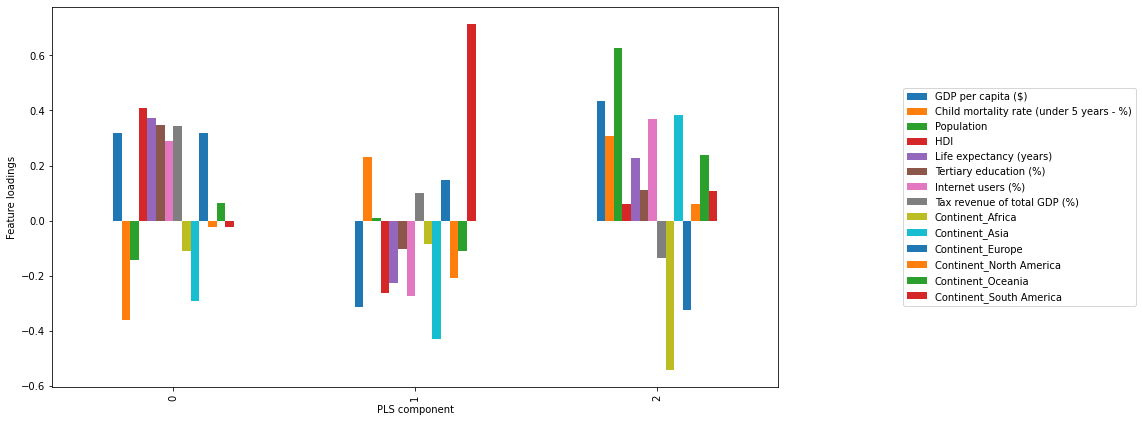

In [66]:
loadings=pd.DataFrame(pls.x_loadings_.T)
loadings.columns = X2.columns

#sns.barplot()

loadings.iloc[0:3,:].plot.bar(figsize=(13,7),xlabel='PLS component',ylabel='Feature loadings').legend(loc='right',bbox_to_anchor=(1.5,0.5))

In [57]:
pls.y_weights_

array([[ 0.20049315,  0.3790693 , -0.12016635]])

[ 0.43274892 -0.09100097  0.04974381]


TypeError: only size-1 arrays can be converted to Python scalars

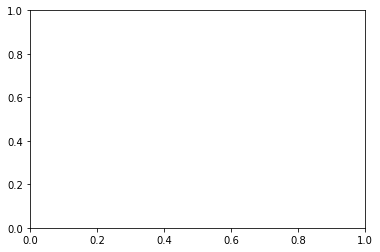

In [25]:
# first component. x and y are plotted seperately due to large size in x
# 1e6 seems extreme. don't know whats wrong 
n = 3
print(pls.x_loadings_[n])
plt.bar(x=np.arange(0,len(pls.x_loadings_[n])), height=pls.x_loadings_)

In [171]:
ca.x_loadings_.shape

(7, 7)

In [172]:
ca.y_loadings_.shape

(8, 7)

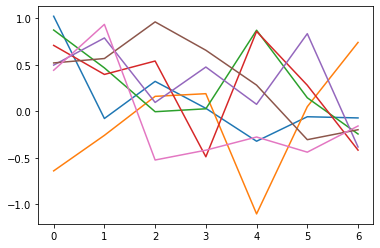

In [173]:
for i in range(n_features):
    plt.plot(ca.x_loadings_[i])


In [224]:
for i in range(n_features):
    plt.plot(ca.y_loadings_[i])

NameError: name 'n_features' is not defined

In [175]:
# pairwise canonical correlations 
np.corrcoef(E_c.T, S_c.T).diagonal(offset=n_features)
# we see quite high correlation in the first and second canonical component. let's plot the corresponding loadings 
# to investigate further


array([0.87027504, 0.72871255, 0.50764589, 0.32906717, 0.18564387,
       0.08108636, 0.04320625])

[ 1.02399363 -0.07679332  0.32285985  0.03268931 -0.32147278 -0.05779218
 -0.07063778]


<BarContainer object of 7 artists>

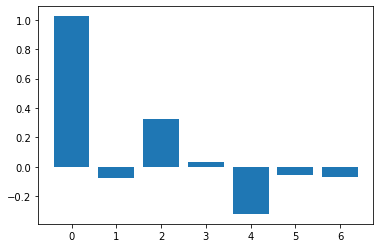

In [176]:
# first component. x and y are plotted seperately due to large size in x
# 1e6 seems extreme. don't know whats wrong 
n = 0
print(ca.x_loadings_[n])
plt.bar(x=np.arange(0,len(ca.x_loadings_[n])), height=ca.x_loadings_[n])

[ 2.18187711e+05  4.81878844e-01 -2.51920933e+00  5.55818112e-01
  5.33068731e-01 -2.36118718e-01 -2.57100657e-02]


<BarContainer object of 7 artists>

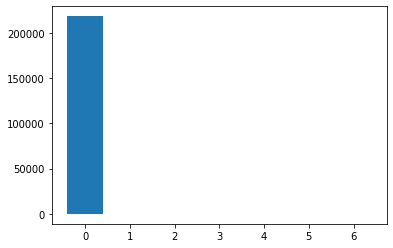

In [177]:
print(ca.y_loadings_[n])
plt.bar(x=np.arange(0,len(ca.y_loadings_[n])), height=ca.y_loadings_[n])

[-0.64062557 -0.25819449  0.16163905  0.19038155 -1.10394689  0.05058746
  0.74213985]


<BarContainer object of 7 artists>

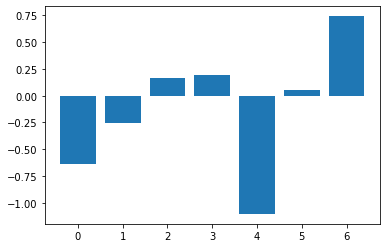

In [182]:
# second component
n = 1
print(ca.x_loadings_[n])
plt.bar(x=np.arange(0,len(ca.x_loadings_[n])), height=ca.x_loadings_[n])

[ 6.97442631e+05 -5.85904595e-01 -4.95421072e-01  2.96265665e-01
 -1.35562859e-01 -2.68237408e-01 -1.02759772e-01]


<BarContainer object of 7 artists>

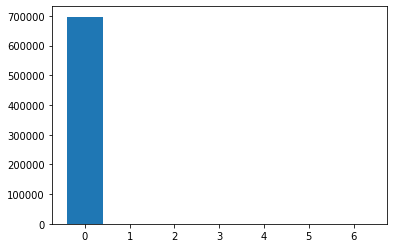

In [183]:
print(ca.y_loadings_[n])
plt.bar(x=np.arange(0,len(ca.y_loadings_[n])), height=ca.y_loadings_[n])

In [372]:
E.columns

Index(['Coal per capita (kWh)', 'Fossil Fuels per capita (kWh)',
       'Energy per capita (kWh)', 'Low-carbon energy per capita (kWh)',
       'Gas per capita (kWh)', 'Nuclear per capita (kWh)',
       'Oil per capita (kWh)', 'Renewables per capita (kWh)',
       'Wind per capita (kWh)', 'Solar per capita (kWh)',
       'Hydro per capita (kWh)'],
      dtype='object')

In [373]:
E.describe()

,Coal per capita (kWh),Fossil Fuels per capita (kWh),Energy per capita (kWh),Low-carbon energy per capita (kWh),Gas per capita (kWh),Nuclear per capita (kWh),Oil per capita (kWh),Renewables per capita (kWh),Wind per capita (kWh),Solar per capita (kWh),Hydro per capita (kWh)
count,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02
mean,1.452235e-16,-4.419845e-17,1.410141e-16,1.341739e-17,-2.157305e-17,3.472736e-17,1.104961e-16,3.604279e-17,4.893400e-17,-3.051798e-17,-8.155667e-18
std,6.094494e-01,6.094494e-01,1.000000e+00,6.094494e-01,6.094494e-01,6.094494e-01,6.094494e-01,6.094494e-01,6.094494e-01,6.094494e-01,6.094494e-01
min,-7.539263e-01,-1.039824e+00,-7.610407e-01,-4.704477e-01,-5.163250e-01,-5.098541e-01,-1.065748e+00,-3.702629e-01,-5.322614e-01,-7.095299e-01,-3.517782e-01
25%,0.000000e+00,-1.453256e-02,-6.562460e-01,-1.513478e-01,-1.184147e-01,-4.731565e-01,0.000000e+00,-2.091313e-01,-2.137349e-01,-1.523820e-02,-1.992487e-01
50%,0.000000e+00,0.000000e+00,-3.658402e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,2.938026e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.324533e+00,5.000612e+00,6.189207e+00,5.259821e+00,6.905125e+00,4.523752e+00,4.748967e+00,5.736283e+00,6.079005e+00,3.851100e+00,5.945571e+00


In [374]:
(df_energy_sub - df_energy_sub.mean())/df_energy_sub.std()

,Coal per capita (kWh),Fossil Fuels per capita (kWh),Energy per capita (kWh),Low-carbon energy per capita (kWh),Gas per capita (kWh),Nuclear per capita (kWh),Oil per capita (kWh),Renewables per capita (kWh),Wind per capita (kWh),Solar per capita (kWh),Hydro per capita (kWh)
0,NaN,NaN,-0.733203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,-0.389777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.731341,-0.752100,-0.448624,-0.467206,-0.226786,-0.509854,-0.835508,-0.366808,-0.531916,-0.649154,-0.348045
3,NaN,NaN,0.572834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-0.681636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
206,-0.743874,-0.291213,0.141644,-0.078062,0.027129,-0.509854,-0.238859,0.047888,-0.532254,-0.706793,0.108415
207,-0.605182,-0.984805,-0.656762,-0.425503,-0.501085,-0.509854,-1.000860,-0.322367,-0.530044,-0.580451,-0.299582
208,NaN,NaN,-0.652240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,NaN,NaN,-0.641635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [375]:
df_energy

,Entity,Unnamed: 0,Year,Coal per capita (kWh),Fossil Fuels per capita (kWh),Energy per capita (kWh),Low-carbon energy per capita (kWh),Gas per capita (kWh),Nuclear per capita (kWh),Oil per capita (kWh),Renewables per capita (kWh),Wind per capita (kWh),Solar per capita (kWh),Hydro per capita (kWh)
0,Afghanistan,4162.5,1999.5,NaN,NaN,875.858550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,4202.5,1999.5,NaN,NaN,11681.020075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,27.5,1992.5,176.147429,9788.705911,9829.523857,40.825750,5870.029732,0.0,3742.528768,0.040826,0.093196,2.920946,37.811661
3,American Samoa,4242.5,1999.5,NaN,NaN,41967.546400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,4282.5,1999.5,NaN,NaN,2498.295825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Venezuela,4058.5,1992.5,78.401054,23739.436250,28401.050446,4661.636893,11017.847196,0.0,12643.187804,4.661637,0.001893,0.132411,4661.502643
207,Vietnam,4114.5,1992.5,1160.075536,2744.903304,3280.915018,536.014250,308.975357,0.0,1275.852375,0.536014,0.597607,6.244732,528.714732
208,Yemen,9176.5,1999.5,NaN,NaN,3423.173625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,Zambia,9216.5,1999.5,NaN,NaN,3756.863325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

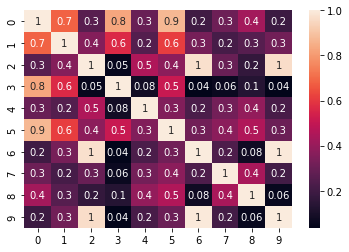

In [376]:
sns.heatmap(np.corrcoef(df_energy.iloc[:,4:].fillna(0).T), annot=True, fmt=".1g")

In [377]:
df_energy.iloc[:,4:].columns

Index(['Fossil Fuels per capita (kWh)', 'Energy per capita (kWh)',
       'Low-carbon energy per capita (kWh)', 'Gas per capita (kWh)',
       'Nuclear per capita (kWh)', 'Oil per capita (kWh)',
       'Renewables per capita (kWh)', 'Wind per capita (kWh)',
       'Solar per capita (kWh)', 'Hydro per capita (kWh)'],
      dtype='object')

In [ ]:
plt.scatter(ca.x_loadings_[b])

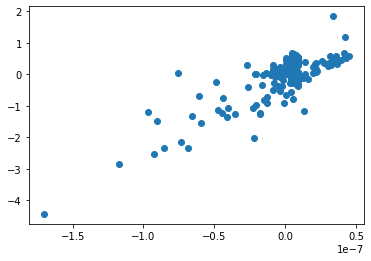

In [384]:
plt.scatter(E_c[:,0], S_c[:,0])

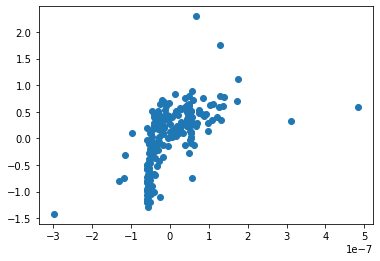

In [385]:
plt.scatter(E_c[:,1], S_c[:,1])

In [396]:
# try with statsmodels instead 
res = CanCorr(E, S)

In [403]:
test =  res.corr_test()

In [410]:
test.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Cancorr results
======================================================================
  Canonical Correlation Wilks' lambda  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------------
0                0.8293        0.1602 88.0000 1248.8154  4.5718 0.0000
1                0.6157        0.5130 70.0000 1114.6975  1.9313 0.0000
2                0.2834        0.8262 54.0000  978.5068  0.6911 0.9563
3                0.2479        0.8984 40.0000  839.7031  0.5225 0.9939
4                0.1691        0.9572 28.0000  697.2936  0.3037 0.9998
5                0.1003        0.9854 18.0000  549.2001  0.1589 1.0000
6                0.0661        0.9954 10.0000  390.0000  0.0895 0.9999
7                0.0144        0.9998  4.0000  196.0000  0.0102 0.9998
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
Multivariate Statistics and F Approximations                          
------------------------------------------------------------------------
                         Value     Num DF     Den DF    F Value   Pr > F
------------------------------------------------------------------------
Wilks' lambda            0.1602   88.0000   1268.4877    4.6438   0.0000
Pillai's trace           1.2518   88.0000   1592.0000    3.3560   0.0000
Hotelling-Lawley trace   3.0097   88.0000    834.7763    6.5138   0.0000
Roy's greatest root      2.2021   11.0000    199.0000   39.8378   0.0000
======================================================================

"""

In [417]:
res.y_cancoef
# same problem with very high values as for the sklearn solution 

array([[-4.82542009e+04,  2.90321676e+05, -3.06785472e+06,
        -2.97390095e+06, -3.60251712e+04, -2.50490485e+06,
         4.26371788e+06,  2.96748000e+06],
       [ 1.87279412e+05, -1.12676748e+06,  1.19066526e+07,
         1.15420081e+07,  1.39817393e+05,  9.72178707e+06,
        -1.65479170e+07, -1.15170881e+07],
       [ 2.96778599e-02, -7.44537236e-02, -7.23952748e-03,
        -1.17017914e-02,  3.19486524e-02,  1.33454104e-02,
        -7.01801007e-03, -1.09252791e-03],
       [-2.91872706e+06,  4.25783225e+06,  2.15800598e+06,
        -1.17913628e+07,  9.65636899e+06, -1.45524078e+07,
        -3.50912963e+07,  2.51325225e+07],
       [-1.25435736e+05,  7.54685005e+05, -7.97482288e+06,
        -7.73059171e+06, -9.36466667e+04, -6.51144641e+06,
         1.10834433e+07,  7.71390092e+06],
       [ 7.04128777e+05, -1.02718141e+06, -5.20608444e+05,
         2.84460917e+06, -2.32955229e+06,  3.51069794e+06,
         8.46560536e+06, -6.06309928e+06],
       [-9.22977443e+04,  5.553101

In [418]:
res.x_cancoef

array([[ 0.0037121 ,  0.01726606,  0.05066436,  0.00893953,  0.06771578,
        -0.03906677,  0.11052893, -0.00304539],
       [ 0.02865076,  0.04868752,  0.04238536, -0.12485755, -0.03833324,
         0.07093466,  0.01732023, -0.0179703 ],
       [ 0.09703245,  0.05745229, -0.0162078 ,  0.0498339 ,  0.01266417,
         0.00707511,  0.02284155,  0.02115765],
       [-0.00232139, -0.06336039, -0.0134714 , -0.01352123, -0.00094294,
        -0.08131871,  0.09057679, -0.19730963],
       [-0.03240037, -0.06218727,  0.020471  ,  0.14173275, -0.0025778 ,
        -0.04222597, -0.00993827,  0.00961535],
       [-0.02582425, -0.08795562,  0.0160177 , -0.0930954 , -0.08282771,
        -0.15914876, -0.06562108, -0.07357351],
       [-0.00381841, -0.07694786, -0.07716397,  0.00020835, -0.00130209,
         0.09479455,  0.05340029, -0.07587967],
       [-0.00427132, -0.00153193,  0.0245836 ,  0.01962866,  0.05996624,
         0.0140704 , -0.03961914, -0.05180522]])

AttributeError: 'CanCorr' object has no attribute 'plot_loadings'